# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [39]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000
SIGMA = 0.01

In [41]:
# A toy model with a diffuse and point source component

def model(z, sigma = SIGMA, w = 0.4):
    x = z + np.random.randn(2)*sigma + (np.random.rand(2)-0.5)*w
    return x

In [42]:
z0 = np.array([0.5, 0.5])
x0 = np.array([0.5, 0.5])

In [43]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/zzzz1")
ds.init(zdim = 2, xdim = (2,))

Loading datastore: /home/ubuntu/volume1/zzzz1


In [44]:
# Instantiate network
sw = swyft.LFI(x0, model, zdim = 2, device = DEVICE, head = None, datastore = ds)

In [45]:
sw.init_train_data(nsamples = 3000)

Constrained posterior area: 1.0
No new simulator runs required.


In [46]:
if sw.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [47]:
sw.init_net1d()

In [48]:
sw.train1d(max_epochs = 10, nbatch = 32)

Start training
LR iteration 0
Total epochs: 9
Validation losses: [3.40339557826519, 3.3213692009449005, 3.30705189704895, 3.3277757614851, 3.3067481368780136, 3.240854248404503, 3.2700237184762955, 3.270319774746895, 3.26456755399704]
LR iteration 1
Total epochs: 10
Validation losses: [3.1593240052461624, 3.1574622690677643, 3.156151160597801, 3.1553824841976166, 3.1546289324760437, 3.1531600058078766, 3.1524225920438766, 3.151728078722954, 3.1508433520793915, 3.150505393743515]
LR iteration 2
Total epochs: 10
Validation losses: [3.1433484256267548, 3.1401465386152267, 3.1388429701328278, 3.1380504816770554, 3.137635514140129, 3.1373613327741623, 3.1371394991874695, 3.136950582265854, 3.136770412325859, 3.1366329193115234]


In [49]:
sw.eval_post1d()

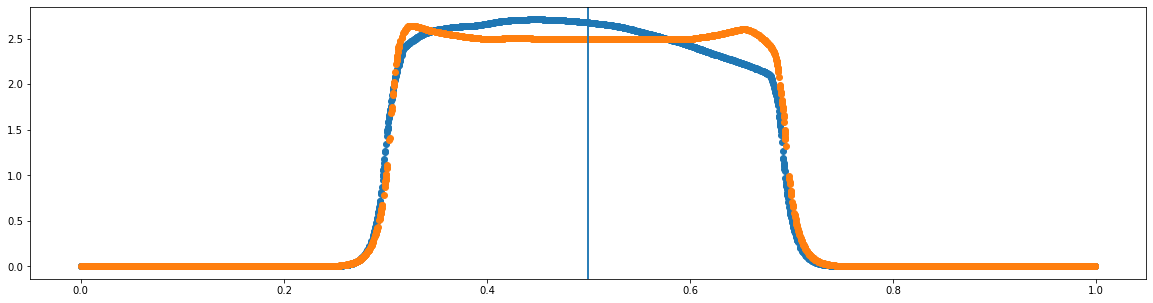

In [50]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [66]:
sw2 = swyft.LFI(x0, model, zdim = 2, device = DEVICE, head = None, datastore = ds, parent = sw)
sw2.init_train_data(nsamples = 10000, threshold = 1e-10)

Constrained posterior area: 0.8387631
Adding 755 new samples. Run simulator!


In [67]:
if sw2.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [68]:
sw2.init_net1d()

In [69]:
sw2.train1d(max_epochs = 1, nbatch = 32)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [3.5768857151269913]
LR iteration 1
Total epochs: 1
Validation losses: [3.5188353806734085]
LR iteration 2
Total epochs: 1
Validation losses: [3.522315636277199]


In [70]:
sw2.eval_post1d()

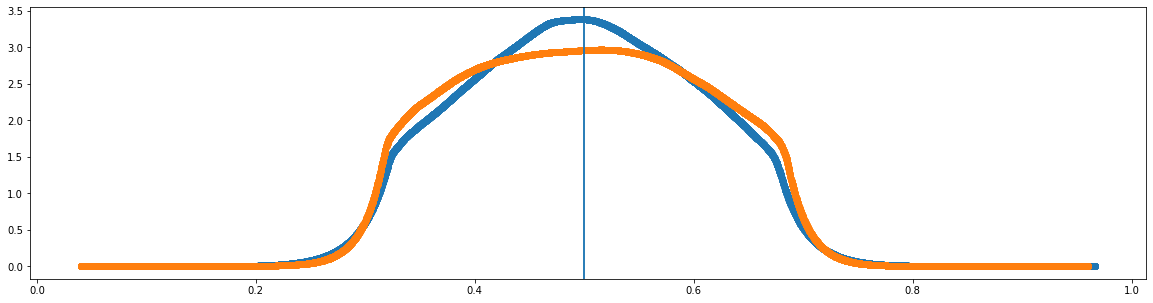

In [71]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw2.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [72]:
sw2.init_netNd([[0, 1]])

In [74]:
sw2.trainNd(max_epochs = 10, nbatch = 128)

Start training
LR iteration 0


KeyboardInterrupt: 

In [75]:
sw2.eval_postNd()

(0.0, 1.0)

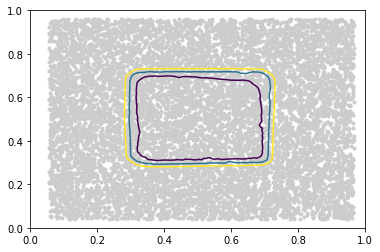

In [79]:
zgrid, lnLgrid = sw2.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], (-lnLgrid+max_lnL)*2, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])